In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN, MeanShift
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

In [2]:
df = pd.read_excel('adel.xlsx', sheet_name=1, index_col=0)

In [3]:
len(df)

618

In [4]:
# From v4 analysis on the full dataset
column_subset = [6, 9, 11, 13, 14, 17, 19, 24, 25]

In [5]:
df = df[['v' + str(x) for x in column_subset]]

## Find distribution of distances

In [6]:
from scipy.stats import expon, lognorm

In [7]:
distances = pairwise_distances(df)
distances = distances.reshape(distances.shape[0] * distances.shape[1])

/home/yrahul/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


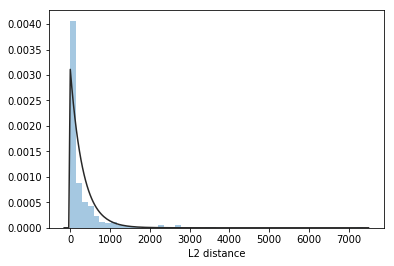

In [8]:
sns.distplot(distances, kde=False, fit=expon, axlabel='L2 distance');

In [9]:
np.mean(distances)

317.45879611537623

In [10]:
np.quantile(distances, 0.5)

92.74518666715666

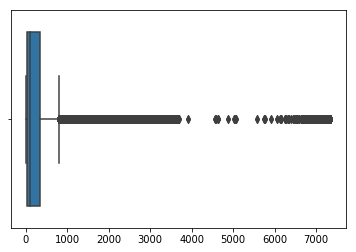

In [11]:
sns.boxplot(distances);

In [12]:
pd.DataFrame(distances, columns=['Distances']).describe()

,Distances
count,381924.000000
mean,317.458796
std,652.525832
min,0.000000
25%,27.693180
50%,92.745187
75%,332.469193
max,7345.623989


In [13]:
indices = np.where(distances == 0)
nonzero_dist = np.delete(distances, indices)

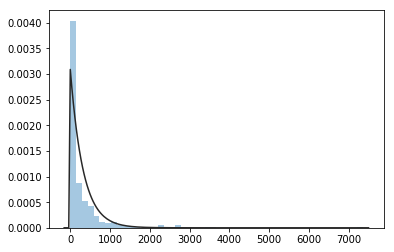

In [14]:
sns.distplot(nonzero_dist, fit=expon, kde=False);

In [15]:
pd.DataFrame(nonzero_dist, columns=['Distances']).describe()

,Distances
count,3.781050e+05
mean,3.206652e+02
std,6.550286e+02
min,9.536743e-07
25%,2.885897e+01
50%,9.528086e+01
75%,3.353583e+02
max,7.345624e+03


In [16]:
first_quartile_dists = nonzero_dist[nonzero_dist < 28]

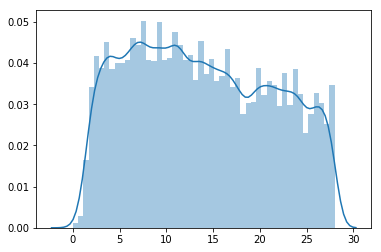

In [17]:
sns.distplot(first_quartile_dists)

In [18]:
zero_to_one = nonzero_dist[nonzero_dist < 1]

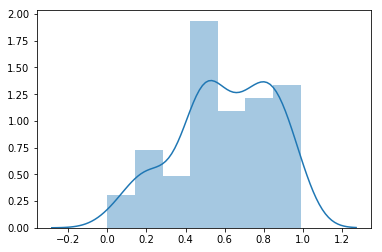

In [19]:
sns.distplot(zero_to_one)

In [20]:
np.mean(zero_to_one)

0.6020348007046117

## DBSCAN

Seeing the peak at 0.5 roughly, for a blind guess, it seems like a reasonable way to select eps.

Edit: DBSCAN returns a label of -1 for individual clusters. I redid this part keeping a threshold of about 10% of the data (60 points) being in individual clusters.

In [21]:
eps = 0.5

while True:
    labels = DBSCAN(eps=eps).fit_predict(df)
    if sum(labels == -1) <= 60:
        break
    
    eps += 0.1

print('eps =', eps)
print('labels =', np.unique(labels))
print('number of individual clusters =', sum(labels == -1))

table = 'Cluster|# Points\n---:|:---\n'
for i in range(len(np.unique(labels))):
    table += str(i-1) + '|'  # To account for -1
    table += str(sum(labels == i-1))
    table += '\n'

display(Markdown(table))

eps = 45.00000000000037
labels = [-1  0  1  2]
number of individual clusters = 60


Cluster|# Points
---:|:---
-1|60
0|532
1|20
2|6


The following cells were run _before_ the above one, but you may run these in any order (this comment was just to add info).

In [22]:
dbscan_labels = DBSCAN().fit_predict(df)

In [23]:
np.unique(dbscan_labels)

array([-1,  0])

In [24]:
sum(dbscan_labels == -1)

561

In [25]:
dbscan_0 = df[dbscan_labels == -1]

In [26]:
dbscan_0

,v6,v9,v11,v13,v14,v17,v19,v24,v25
ID,,,,,,,,,
1,3442.75,21,16,20,320.78,60.66,172.13,8,6.722689
2,2420.70,35,17,25,472.39,58.26,93.10,9,3.910000
3,2727.50,36,26,28,500.05,55.42,113.64,16,6.780000
4,7241.18,77,28,36,1218.80,87.00,147.77,24,6.370000
5,3592.97,55,27,29,710.74,66.68,92.12,18,4.390000
6,2253.53,37,18,25,486.62,33.51,77.70,6,1.760000
7,2668.51,43,26,23,751.61,48.98,56.77,14,4.650000
8,1741.37,28,14,19,258.87,43.70,37.05,3,1.390000
9,816.50,18,14,14,153.60,21.24,42.97,3,1.830000


In [27]:
dbscan_1 = df[dbscan_labels == 0]

In [28]:
dbscan_1.head()

,v6,v9,v11,v13,v14,v17,v19,v24,v25
ID,,,,,,,,,
562,0.0,0,0,0,0.0,0.0,0.0,0,0.0
563,0.0,0,0,0,0.0,0.0,0.0,0,0.0
564,0.0,0,0,0,0.0,0.0,0.0,0,0.0
565,0.0,0,0,0,0.0,0.0,0.0,0,0.0
566,0.0,0,0,0,0.0,0.0,0.0,0,0.0


## Mean Shift Clustering

In [29]:
ms = MeanShift()

In [30]:
preds = ms.fit_predict(df)

In [31]:
np.unique(preds)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [32]:
table = 'Cluster|# Points\n---:|:---\n'
for i in range(12):
    table += str(i) + '|'
    table += str(sum(preds == i))
    table += '\n'

display(Markdown(table))

Cluster|# Points
---:|:---
0|509
1|72
2|19
3|4
4|4
5|3
6|1
7|1
8|1
9|2
10|1
11|1


## Checking if the rows are the same

In [33]:
# Check the 509/532 one
ms_1 = np.where(preds == 0)[0]
dbs_1 = np.where(labels == 0)[0]

In [34]:
len(set(ms_1).intersection(set(dbs_1)))

507

In [35]:
# Check 20/19
ms_2 = np.where(preds == 2)[0]
dbs_2 = np.where(labels == 1)[0]

In [36]:
len(set(ms_2).intersection(set(dbs_2)))

0

In [37]:
# Check 72/60
ms_3 = np.where(preds == 1)[0]
dbs_3 = np.where(labels == -1)[0]

In [38]:
len(set(ms_3).intersection(set(dbs_3)))

21